In [19]:

import os
import copy
import time
import itertools as it

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from sortedcontainers import SortedDict

# Implementation of Basic function

Here is some basic function to tranform SAT file to weighted_adjacency matrix and get clique from graph.

In [20]:
def read_sat(sat_path):
    with open(sat_path) as f:
        sat_lines = f.readlines()
        header = sat_lines[0]
        header_info = header.replace("\n", "").split(" ")
        vars_num = int(header_info[-2])
        clauses_num = int(header_info[-1])

        sat = [
            [int(x) for x in line.replace(" 0\n", "").split(" ")]
            for line in sat_lines[1:]
        ]

        return vars_num, clauses_num, sat


def sat_to_lig_adjacency_matrix(sat, num_vars):
    def get_literal_idx(x): return 2 * x - 2 if x > 0 else 2 * abs(x) - 1
    lig_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    lig_weighted_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    
    for clause in sat:
        pairs = it.combinations(clause, 2)
        for x, y in pairs:
            x_idx = get_literal_idx(x)
            y_idx = get_literal_idx(y)
            lig_adjacency_matrix[x_idx, y_idx] = 1
            lig_adjacency_matrix[y_idx, x_idx] = 1
            lig_weighted_adjacency_matrix[x_idx, y_idx] += 1
            lig_weighted_adjacency_matrix[y_idx, x_idx] += 1

    return lig_weighted_adjacency_matrix


def get_cliques(graph, k):
    cliques = nx.enumerate_all_cliques(graph)
    clique_candidates = []
    for clique in cliques:
        if len(clique) <= k:
            if len(clique) > 1:
                clique_candidates.append(clique)
        else:
            break
    return clique_candidates


def cliques_to_weighted_adjacency_matrix(cliques, num_vars):
    weighted_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    for clique in cliques:
        pairs = it.combinations(clique, 2)
        for pair in pairs:
            x_idx = pair[0]
            y_idx = pair[1]

            weighted_adjacency_matrix[x_idx, y_idx] += 1
            weighted_adjacency_matrix[y_idx, x_idx] += 1

    return weighted_adjacency_matrix


def objective(x, y):
    return np.abs(x - y).sum()/np.count_nonzero(x)




# Convenience function: `run`

As like TSP notebook, I will define `run` to run a clique cover operator (algorithm) on given: weighted adjacency matrix, valid_cliques, and select_clique_num.

In [21]:
def run(cover_opt, instance, weighted_adjacency_matrix, max_clique_size, select_clique_num, num_vars):
    print(f"{'<' * 8} {instance} {'>' * 8}")
    # get the valid cliques from weighted_adjacency_matrix (graph)
    start_time = time.time()
    graph = nx.from_numpy_matrix(weighted_adjacency_matrix)
    valid_cliques  = get_cliques(graph, max_clique_size)
    print(f'cliques enumerate time: {time.time() - start_time:.4f}')
    print(f'valid cliques num: {len(valid_cliques)}')

    # select cliques from valid cliques from the valid cliques
    # your cover_opt will be used in here
    start_time = time.time()
    select_cliques = cover_opt(copy.deepcopy(weighted_adjacency_matrix), valid_cliques, select_clique_num, max_clique_size)
    print(f'cliques cover time: {time.time() - start_time:.4f}')

    # convert the selected cliques to weighted matrix and compare to the given weigthed matrix
    weighted_adjacency_matrix_cover = cliques_to_weighted_adjacency_matrix(select_cliques, num_vars)
    print(f'final objective: {objective(weighted_adjacency_matrix, weighted_adjacency_matrix_cover):.4f}\n') 

# Implement and evaluate your algorithm

Your algortihm will be evaluate on three graphs (sat instances).

In [20]:
class SegmentTree:
    def __init__(self, arr):
        self.tree = [(0, -1)] * (4 * len(arr))
        self.build_tree(arr, 1, 0, len(arr) - 1)

    def build_tree(self, arr, node, start, end):
        if start == end:
            self.tree[node] = (arr[start], start)
        else:
            mid = (start + end) // 2
            self.build_tree(arr, 2 * node, start, mid)
            self.build_tree(arr, 2 * node + 1, mid + 1, end)
            left_val, left_idx = self.tree[2 * node]
            right_val, right_idx = self.tree[2 * node + 1]
            if left_val > right_val:
                self.tree[node] = (left_val, left_idx)
            else:
                self.tree[node] = (right_val, right_idx)

    def query(self, node, start, end, idx):
        if idx < start or idx > end:
            return -1
        elif start == end:
            return self.tree[node][0]
        else:
            mid = (start + end) // 2
            if idx <= mid:
                val = self.query(2 * node, start, mid, idx)
            else:
                val = self.query(2 * node + 1, mid + 1, end, idx)
            return val

    def get_max_value_index (self):
        return self.tree[1][1]

    def update(self, node, start, end, idx, val):
        if start == end:
            self.tree[node] = (val, idx)
        else:
            mid = (start + end) // 2
            if start <= idx and idx <= mid:
                self.update(2 * node, start, mid, idx, val)
            else:
                self.update(2 * node + 1, mid + 1, end, idx, val)
            left_val, left_idx = self.tree[2 * node]
            right_val, right_idx = self.tree[2 * node + 1]
            if left_val > right_val:
                self.tree[node] = (left_val, left_idx)
            else:
                self.tree[node] = (right_val, right_idx)

原算法：找到所有$2,3,...,max\_clique$大小的clique，然后选择前$select\_clique\_num$个

(可能是)一些改进：

## 1

注意到这样一个结构
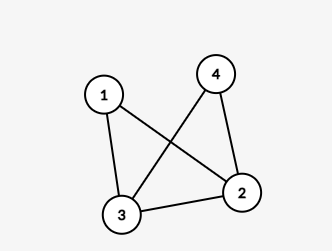

可以用+1的代价用一个4-clique覆盖到这张图。（这里的代价指对objective的影响）

但无法用上述办法覆盖到这个4-clique

---

Q: 如果限定了可以使用的clique，如何做到使用$k$个clique后objective最小

## 1 贪心

记当前图中$weight >0$的边为$+1$，反之为$-1$，每次选weight和最大的clique

这样做问题其实很明显，顶多算是一个还算好的feasible solution

一个可能不太恰当的例子，$k=5$
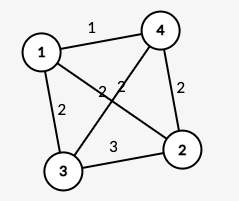

贪心:(1,2,3,4),(1,2,3),(2,3,4),(1,2),(1,3)   obj = 2

最好的解:(1,2,3,4),(1,2,3),(2,3),(3,4),(2,4)  obj = 0

观察到，贪心无法根据k的大小做决策。刚开始选太多很大的clique，可能会导致最后的选择很差

注意到，每个点的contribute是单调递减的，如果上一次的contribute已经不如这次贪心了，就可以略过？



## 2 启发式搜索？

写一个估值函数然后搜，比如，每次记录一个三元组(G,obj,k)，表示目前的图$G$，$objective$和还能覆盖$k$个clique，然后写一个类似这样的f

$$f(obj, k) = a \times obj + b \times k$$

（只是举例子，肯定不能是线性的）

然后根据f来选择下一次往那边搜

初步估计代价很大（记录G是$n^2$的代价，会导致搜索一步的代价就难以承受，并且给$k$写一个很好的估值也很困难

开摆！

## 3 贪心+local search？

贪心找出一个feasible solution，然后local search

额，算子怎么办，第三个数据，clique数有180w个，肯定不能是选两个clique

# 重构思路
1. 只记录(i, j) i<j 的无向边(这个只改了run里的，前面初始化做了双向边，但对run没啥没影响)

2. 对于每条边e，记录对应的clique数量（if e in clique_i, add clique_i to edge_to_clique)

$max_e$ edge_to_clique[e] = 50  (观察出来的)

3. 每次更新，找到最大贡献的clique，然后更新其它所有与它相关的clique

假设最大贡献的clique是k-clique，更新所需要的次数是$50k^2$，为了避免下次需要再排序，用AVL Tree维护。复杂度是$50k^2\log m$, m = valid_cliques_number

感觉应该不慢

一些细节

1. clique_cover()加了arg: max_clique_size


# 复杂度计算

m = valid_cliques_number, n = select_clique_num, k = change times

暴力：O(1) change, O(m) find max，总复杂度O(mn + k)

k怎么计算？有一个比较直觉但不太会严格证的东西

因为是生成了一个相似的SAT instance，我们可以猜 k=the sum of initial clique value. （1）

事实上两者是很接近的（如果不接近，objective也会很大），代码输出里计算了两者，k是update (clique value) times。

值得一提的是，因为每次update只是把某个clique_value -= 2，所以能得到这个结论（1）。

the sum of initial clique value = $\sum_{clique \in SAT} |clique| * (|clique| - 1) / 2$